# Symplectic Euler Shadow Integration of Henon Heils problem

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ShadowIntegrators import *
from CreateTrainingData import *

## data creation for training

In [2]:
# setup problem for creation of training data

# potential and force field
mu = 0.8
V = lambda x: 1/2*(x[0]**2+x[1]**2) + mu*(x[0]**2*x[1]-x[1]**3/3)
f = lambda x: -(x[:2] + mu*(np.array([2*x[0]*x[1],x[0]**2 - x[1]**2])))

# exact Hamiltonian
H = lambda x: 1/2*(x[2]**2+x[3]**2) + V(x)

h = 0.1
spacedim=[(-1., 1.), (-1., 1.),(-1., 1.), (-1., 1.)]
n_train = 800
n_h = 600

In [3]:
# create traing data
start,final = CreateTrainingData(spacedim,f,n_train,h,n_h)

## initialisation and training

In [4]:
# initialise shadow integrator
SI = ShadowSEuler()

In [5]:
# kernel function and derivatives
e   = 5.           # length scale
k   = lambda x,y: np.exp(-1/(e**2)*np.linalg.norm(x-y)**2)
dk  = lambda x,y: 2/e**2*(x-y)*k(x,y)
ddk = lambda x,y: 2/e**2*k(x,y)*(-np.identity(len(x)) + 2/e**2*np.outer(x-y,x-y))

In [6]:
# train integrator
SI.train(start,final,h,k=k,dk=dk,ddk=ddk)          # output: residum of least square problem, rank of linear system

Start training with for 800 data points
Start computation of covariance matrix.
Covariance matrix of shape (800, 800)computed.
Start Cholesky decomposition of (800, 800) Matrix
Cholesky decomposition completed.
Create LHS of linear system for H at test points.
Creation of linear system completed.
Solve least square problem of dimension (3201, 800)


(array([1.25625046e-09]), 800)

## prediction of motion and conservation of exact energy H

In [7]:
## predict a motion starting from z0
N = 5000
z0 = np.array([0.67,0.1,0.,0.])

In [8]:
# use symplectic shadow integration
trj = SI.predictMotion(z0,N)

In [9]:
# integrate exact vector field for comparision, overflow warnings can occur when the trajectory diverges
trjSE = SI.classicTrajectory(z0,lambda z: z[2:],lambda z: f(z[:2]),h,N)

<ipython-input-2-2962339be337>:6: RuntimeWarning: overflow encountered in double_scalars
  f = lambda x: -(x[:2] + mu*(np.array([2*x[0]*x[1],x[0]**2 - x[1]**2])))
<ipython-input-2-2962339be337>:6: RuntimeWarning: invalid value encountered in double_scalars
  f = lambda x: -(x[:2] + mu*(np.array([2*x[0]*x[1],x[0]**2 - x[1]**2])))


Text(0, 0.5, '$q_2$')

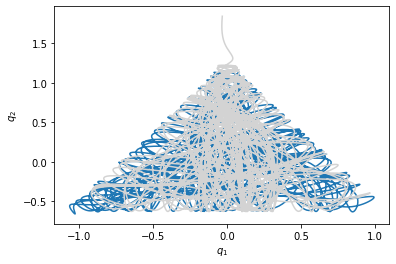

In [11]:
# compare phase plots
m_end = 3980
plt.plot(trj[0,:m_end],trj[1,:m_end])
plt.plot(trjSE[0,:m_end],trjSE[1,:m_end],color='lightgray')
plt.xlabel('$q_1$')
plt.ylabel('$q_2$')

<ipython-input-2-2962339be337>:9: RuntimeWarning: overflow encountered in square
  H = lambda x: 1/2*(x[2]**2+x[3]**2) + V(x)
<ipython-input-2-2962339be337>:5: RuntimeWarning: overflow encountered in square
  V = lambda x: 1/2*(x[0]**2+x[1]**2) + mu*(x[0]**2*x[1]-x[1]**3/3)
<ipython-input-2-2962339be337>:5: RuntimeWarning: overflow encountered in power
  V = lambda x: 1/2*(x[0]**2+x[1]**2) + mu*(x[0]**2*x[1]-x[1]**3/3)
<ipython-input-2-2962339be337>:5: RuntimeWarning: invalid value encountered in subtract
  V = lambda x: 1/2*(x[0]**2+x[1]**2) + mu*(x[0]**2*x[1]-x[1]**3/3)


Text(0, 0.5, '$H$')

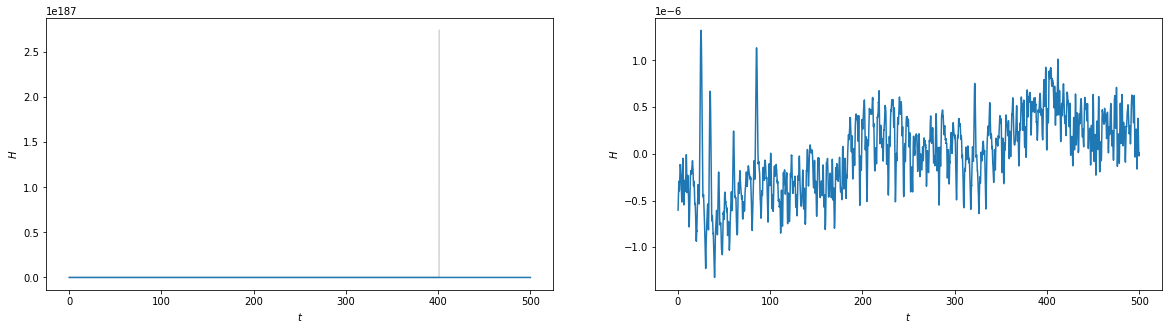

In [12]:
# plot energy conservation
Htrj = H(trj)

fig,ax = plt.subplots(1, 2,figsize=(20,5))
ax[0].plot(h*np.arange(0,len(trj[0,:])),H(trjSE),color='lightgray') # overflow warnings can occur when the trajectory diverges
ax[0].plot(h*np.arange(0,len(trj[0,:])),Htrj)
ax[0].set_xlabel('$t$')
ax[0].set_ylabel('$H$')
ax[1].plot(h*np.arange(0,len(trj[0,:])),Htrj-np.mean(Htrj))
ax[1].set_xlabel('$t$')
ax[1].set_ylabel('$H$')

## system identification

### identify potential

In [13]:
# creation of grid on phase space
n0 = 40
n1 = 40

yy0,yy1 = np.meshgrid(np.linspace(spacedim[0][0],spacedim[0][1],n0),np.linspace(spacedim[1][0],spacedim[1][1],n1))
Y = [ np.array([yy0[i,j],yy1[i,j],0.,0.]) for i in range(0,n1) for j in range(0,n0) ]
Y = np.array(Y)

In [14]:
# compute recovered H over grid
HmodY = np.array([SI.HRecover(x) for x in Y])

In [15]:
# compute reference
n0 = 400
n1 = 400
yy0High,yy1High = np.meshgrid(np.linspace(spacedim[0][0],spacedim[0][1],n0),np.linspace(spacedim[1][0],spacedim[1][1],n1))
V_ref=V([yy0High,yy1High])


Text(0, 0.5, '$q_2$')

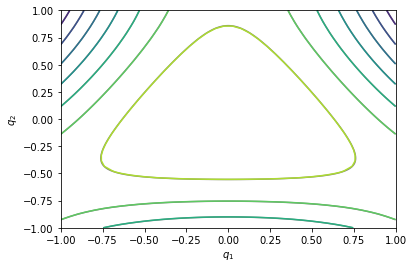

In [16]:
# compare recovered V with reference
plt.contour(yy0High,yy1High,V_ref,colors=['grey'])
plt.contour(yy0,yy1,np.reshape(HmodY[:,2],yy0.shape))
plt.xlabel('$q_1$')
plt.ylabel('$q_2$')

### conservation properties of recovered H along trajectory

In [17]:
# compute recovered H along trajectory
rYt=np.array([SI.HRecover(x) for x in trj.transpose()])

Text(0.5, 0, '$t$')

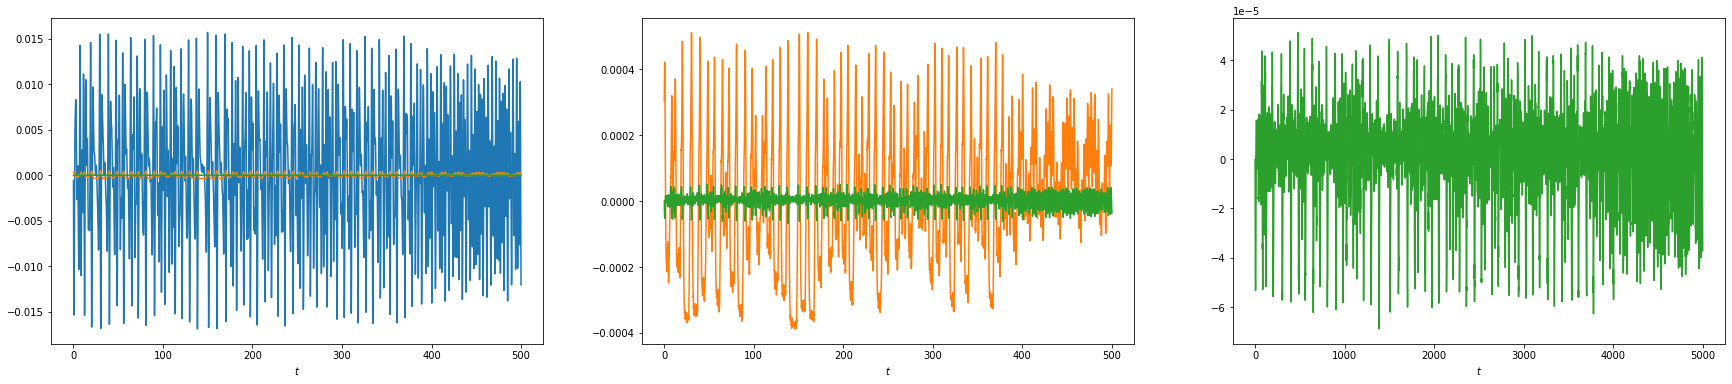

In [18]:
t=h*np.arange(0,len(rYt))
rYtm=np.mean(rYt,0)

fig, axs = plt.subplots(1, 3,figsize=(30,6))
axs[0].plot(t,rYt[:,0]-rYtm[0],t,rYt[:,1]-rYtm[1],t,rYt[:,2]-rYtm[2])
axs[1].plot(t,rYt[:,1]-rYtm[1],'C1',t,rYt[:,2]-rYtm[2],'C2')
axs[2].plot(rYt[:,2]-rYtm[2],'C2')

axs[0].set_xlabel('$t$')
axs[1].set_xlabel('$t$')
axs[2].set_xlabel('$t$')

## Comparison with SciKit GaussianProcessRegressor

In [19]:
# Import libraries
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Fit GP to data with scaled RBF kernel, using ML estimation of the parameters
kernel = C(1.0, (1e-3, 1e5)) * RBF(5, (1e-2, 1e2)) # scaled RBF kernel
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9,random_state=0)
gp.fit(start.T,final.T) 

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=5),
                         n_restarts_optimizer=9, random_state=0)

In [20]:
# predict trajectory using the learned flow map
trjSci = np.zeros((trj.shape[0],4000))
trjSci[:,0] = trj[:,0]

for j in range(0,trjSci.shape[1]-1):
    trjSci[:,j+1] = gp.predict(trjSci[:,j].reshape(1,-1))[0]

Text(0, 0.5, '$q_2$')

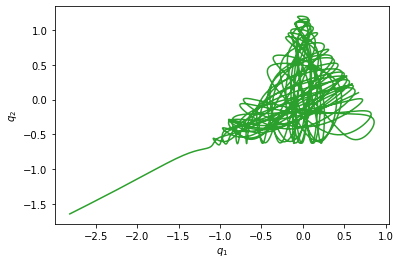

In [21]:
# phase plot
mm = 2278
plt.plot(trjSci[0,:mm],trjSci[1,:mm],'C2')
plt.xlabel('$q_1$')
plt.ylabel('$q_2$')

Text(0, 0.5, '$H$')

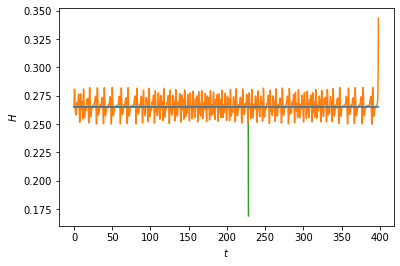

In [22]:
# Compare energy plots
mm1 = 2283
mm = 3983

plt.plot(    h*np.arange(0,mm1),    H(trjSci[:,:mm1]),'C2')
plt.plot(    h*np.arange(0,len(trj[0,:mm])),    H(trjSE[:,:mm]),'C1')
plt.plot(    h*np.arange(0,len(trj[0,:mm])),    H(trj[:,:mm]), 'C0')

plt.xlabel('$t$')
plt.ylabel('$H$')
